<a href="https://colab.research.google.com/github/LivingstonTardzenyuy/Deep-Learning-with-TensorFlow/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling up(Food Vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

The goal is to beat original Food101 paper with 10% of the trainig data using deep learning

In [3]:
!nvidia-smi

Mon Dec 23 05:23:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## creating helper functions.

In previous notebook, we've created a series of helper functions to do different tasks, let's download them.

In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2024-12-23 05:23:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-12-23 05:23:18 (14.1 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [5]:
# Import series of helper functions in notebook.

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: Working with less data

our goal is to beat original Food101 paper with 10% of the trainig data using deep learning.

The data we're downloading comes from original Food101 dataset but has been processed using image_data_modifications notebook in github.


In [6]:

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")


train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-12-23 05:23:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.2’

101_food_classes_10 100%[===================>]   1.51G   235MB/s    in 6.7s    

2024-12-23 05:23:29 (231 MB/s) - ‘101_food_classes_10_percent.zip.2’ saved [1625420029/1625420029]



In [7]:
# How many image/classes are there ?.

walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/sashimi'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/macaroni_and_cheese'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_carbonara'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/shrimp_and_grits'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/edamame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/frozen_yogurt'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/croque_madame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheesecake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/prime_rib'.
There are 0 directories an

In [8]:
# Setup data inputs.

import tensorflow as tf

IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode='categorical',
                                                                                image_size = IMG_SIZE,)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE,
                                                                shuffle=False # don't shuffle the test data
                                                                )


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


# Train a big dog model with transfer learning on 10% of 101 food classes.

Here are the steps we're going to take:
* Create a ModelCheckpoint callback.
* Create a data augmentation layer to biuld data augmentation right into the model
* Build a headless(no top layer) efficientNetB0 backboned-model(we'll create our own layer)
* Compile our model
* Feature extract for 5 full passes


In [9]:
# Create a Checkpoint callback.

checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only = True     # Save only the highest accuracy
                                                         )

In [10]:
  # Create data augmentation layer to incorporate it right into the model.
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.2),
      layers.RandomHeight(0.2),
      layers.RandomWidth(0.2),
      layers.RandomZoom(0.2),
      # layers.experimental.preprocessing.Rescaling(1/255.) # Skip this when using EfficientNetB0 bcause it is already build in. But for ResNet50 include it.
  ], name="data_augmentation")

 ## Model 1: Feature Extraction Transfer Learning with 10% of the data using Data Augmentation

In [11]:
# Setup input shpae and base model, freezing the base model layers.

input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False
)
base_model.trainable = False

# Create input layer.
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation sequential model as a layer.
x = data_augmentation(inputs)  # augment image

# Give the base model the inputs (after augmentation) and don't train it.
x = base_model(x, training=False)

# Pool out features of the base model.
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Create the output activation layer.
outputs = layers.Dense(101, activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs=inputs, outputs = outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 101)                 │         129,381 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [12]:
# Compile the model.
model.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model.
history_all_classes_10_percent = model.fit(
    train_data_all_10_percent.repeat(),
    epochs = 5,
    steps_per_epoch = len(train_data_all_10_percent),
    validation_data = test_data,
    validation_steps = int(0.15 * len(test_data)),   # Validate on 15% of the data during training
    callbacks = [checkpoint_callback ]
)

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 59s 190ms/step - accuracy: 0.1275 - loss: 4.0822 - val_accuracy: 0.3655 - val_loss: 2.8180
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 42s 179ms/step - accuracy: 0.4152 - loss: 2.5910 - val_accuracy: 0.4102 - val_loss: 2.3243
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 170ms/step - accuracy: 0.4939 - loss: 2.1722 - val_accuracy: 0.5797 - val_loss: 1.7659
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 169ms/step - accuracy: 0.5313 - loss: 1.9537 - val_accuracy: 0.5726 - val_loss: 1.7355
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 171ms/step - accuracy: 0.5537 - loss: 1.8093 - val_accuracy: 0.5967 - val_loss: 1.6434


In [13]:
# Evaluate on the whole test dataset.
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms/step - accuracy: 0.5013 - loss: 1.9430


[1.8109403848648071, 0.5330693125724792]

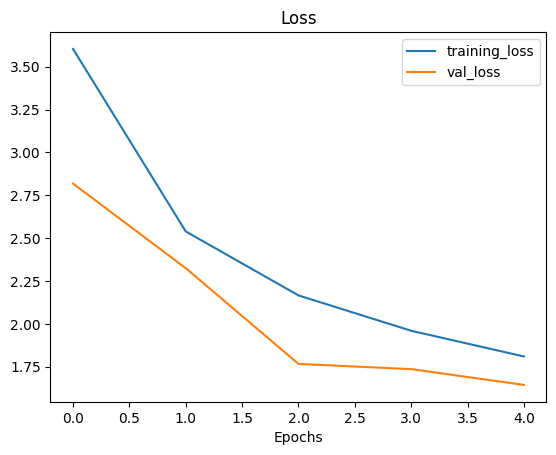

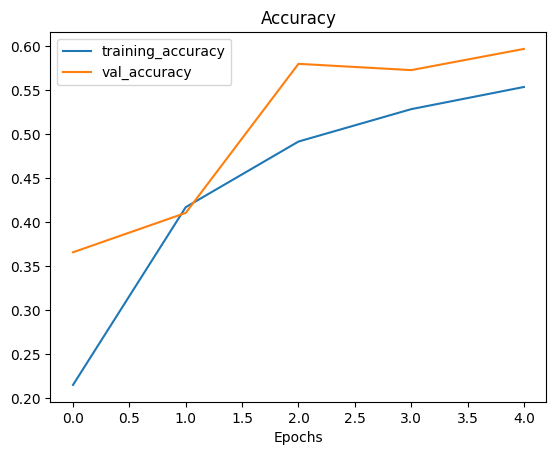

In [14]:
# Plot loss curves.

plot_loss_curves(history_all_classes_10_percent)

## Fine-tuning

In [15]:
# Unfreeze all of the layers in the base model

base_model.trainable = True

# Refreeze every layer except for the last 5.
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
Ended in 007 video........................